This Jupyter notebook is used for proving the Kalman filter online regression:

First it creates synthesized raw gas resitance, temperature, absolute humidity time series with selectable parameters and linear dependencies:

- gas_resistance_compensated = f1(g0, dg, f_g0);   f1=g0+dg*np.power(np.sin(df['index']*f_g0*2*math.pi),3)
- temperature                = f2(T0, dT, f_T0);   f2=T0+dT*np.power(np.cos(df['index']*f_T0*2*math.pi),5)
- absolute_humidity          = f3(aH0, dH, f_aH0); f3=aH0+dH*np.power(np.sin(df['index']*f_aH0*2*math.pi),7)

The synthesized gas_resistance_raw is then calculated by the following linear equation:

- gas_resistance_raw = gas_resistance_compensated + alpha * temperature + beta * absolute_humidity

In Python Pandas sytax this translates into

df["gas_resistance_raw"] =  df["gas_resistance_compensated"] + alpha*df["temperature"] + beta*df["absolute_humidity"]

The synthesized triple ['gas_resistance_raw','temperature','absolute_humidity'] is then fed into the Kalman filter
The Kalman filter is set up in such a way that is executing an online linear regression for estimation of the coefficients alpha and beta.

Please check at the 'Results' section at the bottom of the notebook the estimated alpha and beta coefficients.

There may be a small deviating between defined and estimated regression coefficients if the number of ventilation cycles is quite small, e.g. few days only. In reality we get one or two major ventilation cycles each day. When ventilation the temperature and absolute humidity have bigger changes that are then influencing the regression results. 

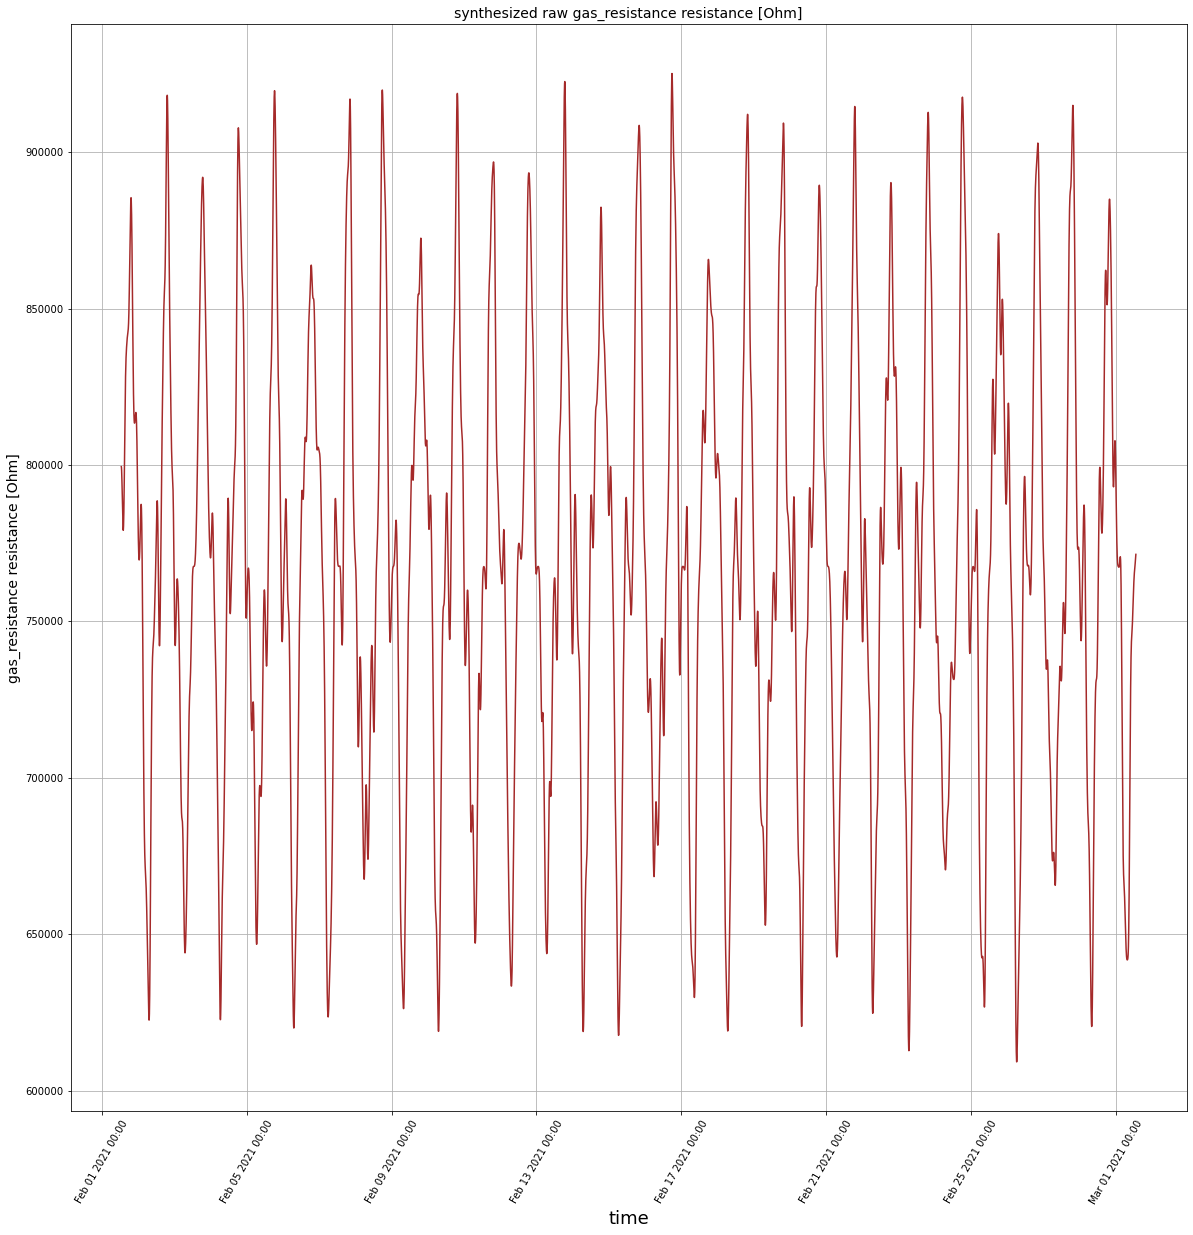

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import math
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

number_of_days   = 28 # duration of the synthesized data set used for the online regression 
time_step        = 4  # in minutes; sampling time of sensor

number_of_points = int(number_of_days * 24 * 60 / time_step) + 1  # cxalculated; do not change!

g0               = 250000           # base value of gas_resistance_raw
dg               = g0/2             # modulation of gas_resistance_raw
f_g0             = 1                # frequency of gas_resistance_raw in days

T0               = 23               # base value of temperature
dT               = 1.567            # modulation of temperature
f_T0             = 2.37             # frequency of temperature in days

aH0              = 7.3              # base value of absolute_humidity
dH               = 3.5              # modulation of absolute_humidity
f_aH0            = 2.2557           # frequency of absolute_humidity in days


# change the cooefficients 'alpha' and 'beta' here and check at the end of the notebook to what extend the Kalman filter is estimating them accurately
alpha            = 20345             # linear dependency coefficient of temperature
beta             = 6800.56           # linear dependency coefficient of absolute_humidity

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))

# you may choose another start date in 'pd.date_range('2021-02-01 12:59:59.50', periods=number_of_points, freq=str(time_step)+"T")':

start_date  = '2021-02-01 12:59:59.50'

df=pd.DataFrame({"time"                      : pd.date_range(start_date, periods=number_of_points, freq=str(time_step)+"T"),
                "index"                      : np.linspace(0,number_of_days, num=number_of_points)})

df["index"] = df["index"].astype(np.float64)

df=pd.DataFrame({"time"                      : pd.date_range(start_date, periods=number_of_points, freq=str(time_step)+"T"),
                "index"                      : np.linspace(0,number_of_days, num=number_of_points),
                "gas_resistance_compensated" : g0+dg*np.power(np.sin(df['index']*f_g0*2*math.pi),3),
                "temperature"                : T0+dT*np.power(np.cos(df['index']*f_T0*2*math.pi),5),
                "absolute_humidity"          : aH0+dH*np.power(np.sin(df['index']*f_aH0*2*math.pi),7)})

df["gas_resistance_raw"] =  df["gas_resistance_compensated"] + alpha*df["temperature"] + beta*df["absolute_humidity"]

ax.plot_date(df['time'], df['gas_resistance_raw'], linestyle='solid', marker=" ", color='brown')         
plt.title('synthesized raw gas_resistance resistance [Ohm]', fontsize=14)
plt.xlabel('time', fontsize=18)
plt.ylabel('gas_resistance resistance [Ohm]', fontsize=14)
plt.grid(True)

plt.show()

In [2]:
#my_series = df[['index','time','gas_resistance_raw']] 
#my_series

In [3]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)             # Predicted (a priori) state estimate
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q      # Predicted (a priori) estimate covariance
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)                                  # Innovation or measurement pre-fit residual
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))           # Innovation (or pre-fit residual) covariance
        #print("\nUpdate: self.H = ", self.H)
        #print("\nUpdate: self.P = ", self.P)
        #print("\nUpdate: self.R = ", self.R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))          # Optimal Kalman gain
        #print("\nUpdate: Kalman gain matrix K  = ", K)
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T) # Updated (a posteriori) estimate covariance 
        

In [4]:
my_observations = df[['gas_resistance_raw','temperature','absolute_humidity']] 
my_observations.head()

,gas_resistance_raw,temperature,absolute_humidity
0,799459.703000,24.567000,7.300000
1,799324.250205,24.560310,7.300000
2,798923.564997,24.540386,7.300000
3,798270.582388,24.507671,7.300001
4,797383.898199,24.462882,7.300008


In [5]:
list_of_rows = [list(row) for row in my_observations.values]
print(list_of_rows[:4])

[[799459.703, 24.567, 7.3], [799324.2502050619, 24.560309546850604, 7.300000000512146], [798923.5649971225, 24.540386493732182, 7.300000065199914], [798270.5823882935, 24.507671074732002, 7.300001103968236]]


In [6]:
np.array(list_of_rows)
measurements = np.array(list_of_rows)
print("number of measurement datapoints = ", len(measurements))

number of measurement datapoints =  10081


In [7]:
F = np.eye(3)
H = np.array([ [1, 1, 1] ]).reshape(1, 3)
# key ist to set Q to a zero matrix, in this case the Kalman filter works an ordinary least squares minimizer filter
q0 = 0.0
Q = np.array([ [q0, q0, q0], [q0, q0, q0], [q0, q0, q0] ]).reshape(3, 3)
# set covariance of gas_resistancet resistance measurements also to a very small value
R = np.array([ [0.0001] ]).reshape(1, 1)

print("\nF = ",F)  # the state-transition model;
print("\nInitial H = ",H)  # the observation model;
print("\nQ = ",Q)  # covariance of the process noise
print("\nR = ",R)  # covariance of the observation noise


F =  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Initial H =  [[1 1 1]]

Q =  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

R =  [[0.0001]]


In [8]:
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
compensatedensated_gas_resistance_resistance=[]
states=[]

#print("raw gas_resistance resistance measurements =", measurements[:,0])

print("dim measurements : ", measurements.shape)

last_index = len(measurements)

print ("last index of measurement array = ", last_index)

dim measurements :  (10081, 3)
last index of measurement array =  10081


In [9]:
it = 0  # iteration index
#print("\nState vector kf.x= ", kf.x)
for z in measurements:
    zg = z[0] # raw_gas_resistance_resistance
    # make observation model matrix state dependant
    H = np.array([[1, z[1], z[2]]]).reshape(1, 3)
    # z[1]: measured temperatureerature
    # z[2]: calculated absolute humidity absolute_humidity(T, rH)
    # estimated state vector x:
    # x[0]: estimated VOC resistance
    # x[1]: estimated regression coefficient for T temperatureerature dependency
    # x[2]: estimated regression coefficient for absolute_humidity aboslute humidity dependency
    kf.H = H
    it = it + 1
    #print("\nState vector kf.x= ", kf.x)
    #print results for the last sample of the measurement sequence
    if ((it == last_index)):  # print results of last measurement index 
        print ("\nIteration index = ", it)
        print ("\n")
        print("\nState vector kf.x= ", kf.x)
        print("\nObservation vector z = ", z)
        print("\nObservation transition matrix kf.H = ", kf.H)
        print("\nKalman filter prediction = ", kf.predict())
        print("\nKalman filter update = ",np.dot(H,  kf.predict()))
        print ("\n\n")
    predictions.append(np.dot(H,  kf.predict()))
   
    compensatedensated_gas_resistance_resistance.append(zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    #compensatedensated_gas_resistance_resistance.append(-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    #compensatedensated_gas_resistance_resistance.append(-kf.predict()[1,0]*z[1])
    #rint("\nraw gas_resistance resistance                = ",zg)
    #print("\ntemperatureerature coefficent prediction = ",kf.predict()[1,0])
    #print("\ntemperatureerature                       = ",z[1])
    #print("\ntemperatureerature compensatedensation          = ",-kf.predict()[1,0]*z[1])
    #print("\nhumidity coefficent prediction    = ",kf.predict()[2,0])
    #print("\nabsolute humidity                 = ",z[2])
    #print("\nhumidity compensatedensation             = ",-kf.predict()[2,0]*z[2])
    #print("\nKalman state prediction          = ",kf.predict())
    #print("\ntemperature coefficent prediction = ",kf.predict()[1,0])
    #print("\ncompensatedensated gas_resistance resistance       = ",zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    states.append(kf.x)
    kf.update(zg)  #only zg raw_gas_resistance_resistance is an observation variable!


Iteration index =  10081



State vector kf.x=  [[265360.01654918]
 [ 19625.76523353]
 [  6962.72224526]]

Observation vector z =  [7.71424206e+05 2.28351037e+01 8.35872659e+00]

Observation transition matrix kf.H =  [[ 1.         22.83510366  8.35872659]]

Kalman filter prediction =  [[265360.01654918]
 [ 19625.76523353]
 [  6962.72224526]]

Kalman filter update =  [[771715.89165371]]





# Results

## Plot alpha (temperature coefficient) and beta (aH coefficient) regression coefficients

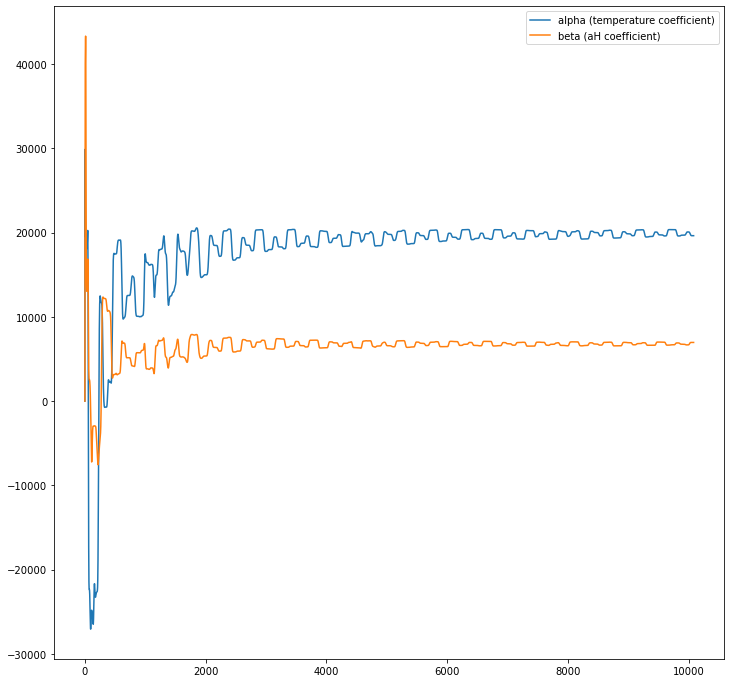

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(range(len(predictions)), np.array(states)[:,1], label = 'alpha (temperature coefficient)')
ax.plot(range(len(predictions)), np.array(states)[:,2], label = 'beta (aH coefficient)')
ax.legend()
plt.show()

In [11]:
print("\n\nnumber of days for Kalman filtering                      = %11.1lf days\n\n" % number_of_days)

print("\n\nset temperature coefficent 'alpha'                       =  %11.1lf" % alpha)
print("\ntemperature coefficent 'alpha' prediction                =  %11.1lf" % kf.predict()[1,0])
print("\nprediction error of temperature coefficent 'alpha'       =  %11.2lf %%" % ((alpha -kf.predict()[1,0])/alpha*100.0) )



number of days for Kalman filtering                      =        28.0 days




set temperature coefficent 'alpha'                       =      20345.0

temperature coefficent 'alpha' prediction                =      19625.8

prediction error of temperature coefficent 'alpha'       =         3.54 %


In [12]:
print("\n\nset nabsolute_humidity coefficent 'beta'                  = %11.1lf" % beta)
print("\nabsolute_humidity coefficent 'beta' prediction            = %11.1lf" % kf.predict()[2,0])
print("\nprediction error of absolute_humidity coefficent 'beta'   = %11.2lf %%" % ((beta -kf.predict()[2,0])/beta*100.0) )



set nabsolute_humidity coefficent 'beta'                  =      6800.6

absolute_humidity coefficent 'beta' prediction            =      6962.7

prediction error of absolute_humidity coefficent 'beta'   =       -2.38 %


# Please play with the parameter 'number_of_days' above
Increase set value of 'number_of_days above' and check the influence on the accuracy of the estimation.
- We can see that we need at least 14 days in order to get a reasonably low error of the estimation.
- After 4 days the estimation error is still significantly high!
- The estimation accuracy will improve when the Kalman filter will run for a longer time, e.g. for >> 14 days
- Since we have an online regression, the Kalman filter will be able to adapt to slowly changing paramaters, e.g. in the different seasons

# Done 